In [1]:
import pandas as pd
df = pd.read_csv('sevennet_slopes.csv')

df.loc[df['v1_Li_slope'] <= 0, 'v1_Li_slope'] = 1e-15

In [2]:
import torch

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

In [3]:
import os
import ase.io
import numpy as np
from sevenn.sevennet_calculator import SevenNetCalculator
from e3nn.o3 import Irreps, Linear
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch

folder_name = '/mnt/hdd/maevskiy/MLIAP-MD-data/gpu_prod/'

temprature = 1000

mean = 0.0    
noise = 0.01  

radial_cutoff = 5

number_noise_samples = 1

dataset = []

for file_name in tqdm(os.listdir(folder_name)):
    forces_noise_samples = []
    material_id = '-'.join(file_name.split('-')[:2])
    if material_id == 'mp-1104241':
        continue
    if f'T1000' in file_name:
        for _ in range(number_noise_samples):
            material_id = '-'.join(file_name.split('-')[:2])
            atoms = ase.io.read(os.path.join(folder_name, file_name, 'md.traj'), index = 0)
            calc = SevenNetCalculator('7net-0', device='cpu')
            atoms.calc = calc
            positions = atoms.get_positions() 
            atoms.set_positions(positions + noise)

            force = atoms.get_forces(apply_constraint=False)

            edge_src, edge_dst, edge_shift = ase.neighborlist.neighbor_list("ijS", a=atoms, cutoff=radial_cutoff, self_interaction=True)
  
            log_diffusion = np.log10(df[(df['mpid'] == material_id) & (df['temperature'] == 1000)]['v1_Li_slope'].iloc[0])

            data = Data(
                pos=torch.tensor(atoms.get_positions(), dtype=torch.float32),
                x=torch.tensor(force),
                lattice=torch.tensor(atoms.cell.array, dtype=torch.float32).unsqueeze(0),  # We add a dimension for batching
                edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
                edge_shift=torch.tensor(edge_shift, dtype=torch.float32),
                target = torch.tensor(log_diffusion, dtype=torch.float32)
            )

            dataset.append(data)

100%|██████████| 420/420 [06:12<00:00,  1.13it/s]


In [4]:
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

In [5]:
train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]

In [6]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [7]:
from simple_network.gate_points_networks import SimpleNetwork
from typing import Dict, Union
import torch_scatter

class SimplePeriodicNetwork(SimpleNetwork):
    def __init__(self, **kwargs) -> None:
        """The keyword `pool_nodes` is used by SimpleNetwork to determine
        whether we sum over all atom contributions per example. In this example,
        we want use a mean operations instead, so we will override this behavior.
        """
        self.pool = False
        if kwargs['pool_nodes'] == True:
            kwargs['pool_nodes'] = False
            kwargs['num_nodes'] = 1.
            self.pool = True
        else:
            kwargs['num_nodes'] = 1.
        super().__init__(**kwargs)

    # Overwriting preprocess method of SimpleNetwork to adapt for periodic boundary data
    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        edge_src = data['edge_index'][0]  # Edge source
        edge_dst = data['edge_index'][1]  # Edge destination

        # We need to compute this in the computation graph to backprop to positions
        # We are computing the relative distances + unit cell shifts from periodic boundaries
        edge_batch = batch[edge_src]
        edge_vec = (data['pos'][edge_dst]
                    - data['pos'][edge_src]
                    + torch.einsum('ni,nij->nj', data['edge_shift'], data['lattice'][edge_batch]))

        return batch, data['x'], edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        # if pool_nodes was set to True, use scatter_mean to aggregate
        output = super().forward(data)
        if self.pool == True:
            return torch_scatter.scatter_mean(output, data.batch, dim=0)  # Take mean over atoms per example
        else:
            return output


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

# Function for the training phase
def train_epoch(model, train_dataloader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for data in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(data).squeeze()
        loss = criterion(outputs, data['target'])
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    return avg_train_loss

# Function for the validation phase
def validate_epoch(model, val_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for data in val_dataloader:
            outputs = model(data).squeeze()
            loss = criterion(outputs, data['target'])
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    return avg_val_loss

# Function to train and validate the model over multiple epochs
def train(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    epochs = []

    for epoch in range(num_epochs):
        # Training phase
        avg_train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
        train_losses.append(avg_train_loss)

        # Validation phase
        avg_val_loss = validate_epoch(model, val_dataloader, criterion)
        val_losses.append(avg_val_loss)

        # Print progress and plot loss curves
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        # Plotting
        clear_output(True)
        plt.figure(figsize=(15, 10))

        # Plot train loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='blue')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss', color='red')
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()


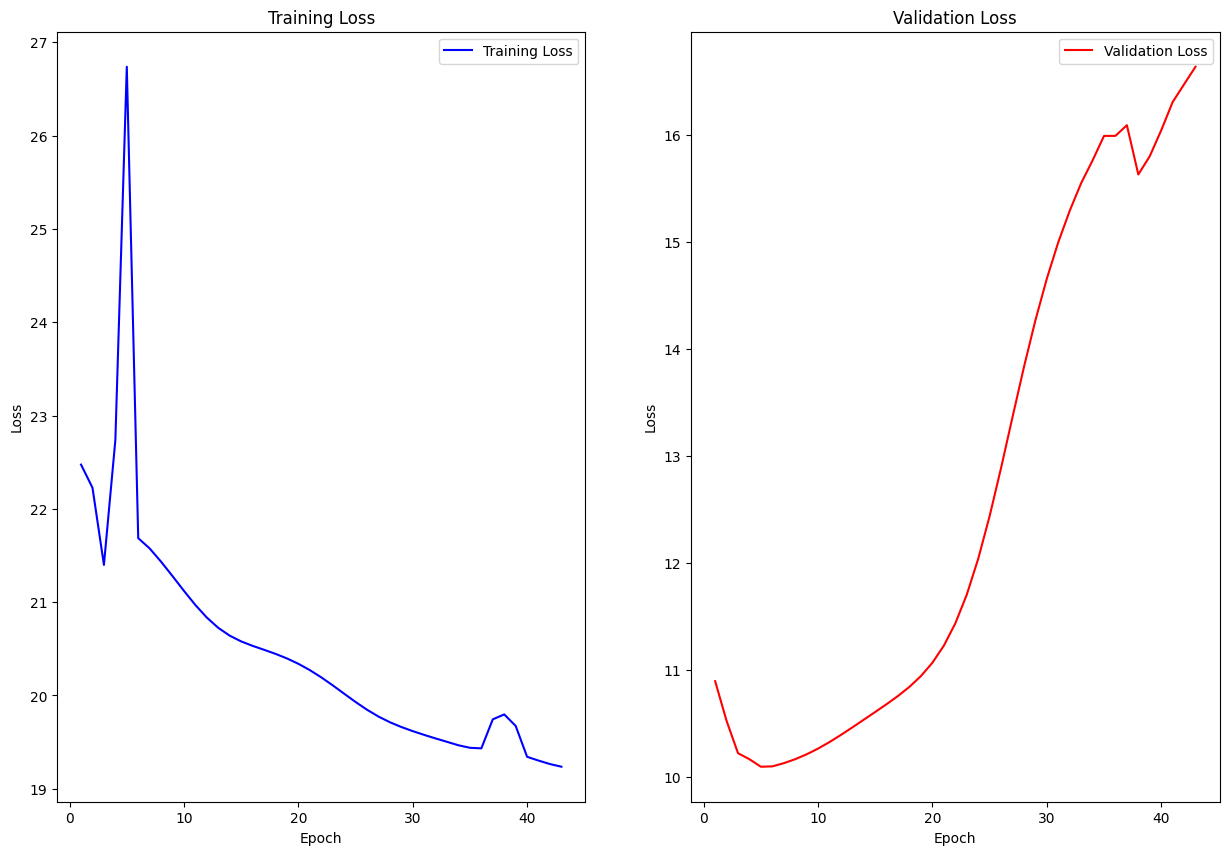

In [ ]:
import torch.optim as optim
import torch.nn as nn


radial_cutoff = 5

net = SimplePeriodicNetwork(
    irreps_in="1x1o",  
    irreps_out="1x0e",  # Single scalar (L=0 and even parity) to output (for example) energy
    max_radius=radial_cutoff, # Cutoff radius for convolution
    num_neighbors=10.0,  # scaling factor based on the typical number of neighbors
    pool_nodes=True,  # We pool nodes to predict total energy
)

criterion = nn.MSELoss()  # Example: Mean Squared Error
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 50

train(net, train_dataloader, val_dataloader, optimizer, criterion, num_epochs)